In [142]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import L2


In [143]:
def preprocess_data(csv_file):
    df = pd.read_csv(csv_file)
    if len(df) < 10:
        print(f"Skipping {csv_file} - only {len(df)} samples")
        return None, None, None, None, None
    
    X = df.drop(columns=['state', 'video_name', 'view', 'segment_duration', 'is_overlap'])
    y = LabelEncoder().fit_transform(df['state'])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test, len(df)


In [144]:
def build_model(input_dim, output_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim, kernel_regularizer=L2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(32, activation='relu', kernel_regularizer=L2(0.05)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(16, activation='relu', kernel_regularizer=L2(0.005)),
        BatchNormalization(),
        Dropout(0.1),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [145]:
def train_model(model, X_train, y_train):
    return model.fit(
        X_train, y_train,
        epochs=40,
        batch_size=16,
        validation_split=0.2,
        verbose=0
    )



In [146]:
def evaluate_model(model, history, X_test, y_test, csv_file, sample_count):
    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    test_acc = model.evaluate(X_test, y_test, verbose=0)[1]

    print(f"\n{os.path.basename(csv_file)} Results:")
    print(f"Final Training Accuracy: {train_acc:.4f}")
    print(f"Final Validation Accuracy: {val_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    return {
        'segment': os.path.basename(csv_file),
        'train_accuracy': train_acc,
        'val_accuracy': val_acc,
        'test_accuracy': test_acc,
        'samples': sample_count,
        'history': history.history
    }



In [147]:
def visualize_histories(results):
    plt.figure(figsize=(18, 12))

    plt.subplot(2, 2, 1)
    for res in results:
        plt.plot(res['history']['accuracy'], label=res['segment'])
    plt.title('Training Accuracy')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy')
    plt.legend(); plt.grid(alpha=0.2)

    plt.subplot(2, 2, 2)
    for res in results:
        plt.plot(res['history']['loss'], label=res['segment'])
    plt.title('Training Loss')
    plt.xlabel('Epochs'); plt.ylabel('Loss')
    plt.legend(); plt.grid(alpha=0.2)

    plt.subplot(2, 2, 3)
    for res in results:
        plt.plot(res['history']['val_accuracy'], label=res['segment'])
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy')
    plt.legend(); plt.grid(alpha=0.2)

    plt.subplot(2, 2, 4)
    for res in results:
        plt.plot(res['history']['val_loss'], label=res['segment'])
    plt.title('Validation Loss')
    plt.xlabel('Epochs'); plt.ylabel('Loss')
    plt.legend(); plt.grid(alpha=0.2)

    plt.tight_layout()
    plt.show()

def visualize_test_accuracy(comparison_df):
    plt.figure(figsize=(15, 8))
    sorted_df = comparison_df.sort_values('Test Acc')
    plt.barh(sorted_df['Segment'], sorted_df['Test Acc'], color='teal')
    plt.title('Test Accuracy by Segment')
    plt.xlabel('Accuracy'); plt.grid(axis='x', alpha=0.4)
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()

def plot_feature_correlations(csv_file):
    df = pd.read_csv(csv_file)
    numerical_cols = [
        'flow_mean', 'flow_std', 'flow_max', 'orientation_mean',
        'orientation_std', 'temporal_grad_mean', 'temporal_grad_std',
        'temporal_grad_max', 'dominant_freq', 'flow_entropy',
        'motion_consistency', 'total_frames', 'actual_fps'
    ]
    corr_matrix = df[numerical_cols].corr()

    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', center=0)
    plt.title('Feature Correlation Heatmap')
    plt.xticks(rotation=45); plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()



In [148]:
def run_pipeline(segment_files):
    results = []
    for csv_file in segment_files:
        print(f"\n{'='*40}\nProcessing {csv_file}")
        X_train, X_test, y_train, y_test, sample_count = preprocess_data(csv_file)
        if X_train is None:
            continue
        model = build_model(input_dim=X_train.shape[1], output_dim=len(np.unique(y_train)))
        history = train_model(model, X_train, y_train)
        result = evaluate_model(model, history, X_test, y_test, csv_file, sample_count)
        results.append(result)
    
    comparison_df = pd.DataFrame([{
        'Segment': r['segment'],
        'Train Acc': r['train_accuracy'],
        'Val Acc': r['val_accuracy'],
        'Test Acc': r['test_accuracy'],
        'Samples': r['samples']
    } for r in results]).sort_values('Test Acc', ascending=False)

    print("\n=== Final Model Comparison ===")
    print(comparison_df)

    visualize_histories(results)
    visualize_test_accuracy(comparison_df)



Processing final_dataset_csv/5s.csv

5s.csv Results:
Final Training Accuracy: 0.7941
Final Validation Accuracy: 0.6667
Test Accuracy: 0.6818

Processing final_dataset_csv/5s_overlap.csv

5s_overlap.csv Results:
Final Training Accuracy: 0.7956
Final Validation Accuracy: 0.7714
Test Accuracy: 0.8409

Processing final_dataset_csv/10s.csv

10s.csv Results:
Final Training Accuracy: 0.7647
Final Validation Accuracy: 0.3333
Test Accuracy: 0.2727

Processing final_dataset_csv/10s_overlap.csv

10s_overlap.csv Results:
Final Training Accuracy: 0.8281
Final Validation Accuracy: 0.7059
Test Accuracy: 0.6190

Processing final_dataset_csv/15s.csv

15s.csv Results:
Final Training Accuracy: 0.7727
Final Validation Accuracy: 0.1667
Test Accuracy: 0.6250

Processing final_dataset_csv/15s_overlap.csv

15s_overlap.csv Results:
Final Training Accuracy: 0.8293
Final Validation Accuracy: 0.7273
Test Accuracy: 0.8571

=== Final Model Comparison ===
           Segment  Train Acc   Val Acc  Test Acc  Samples
5

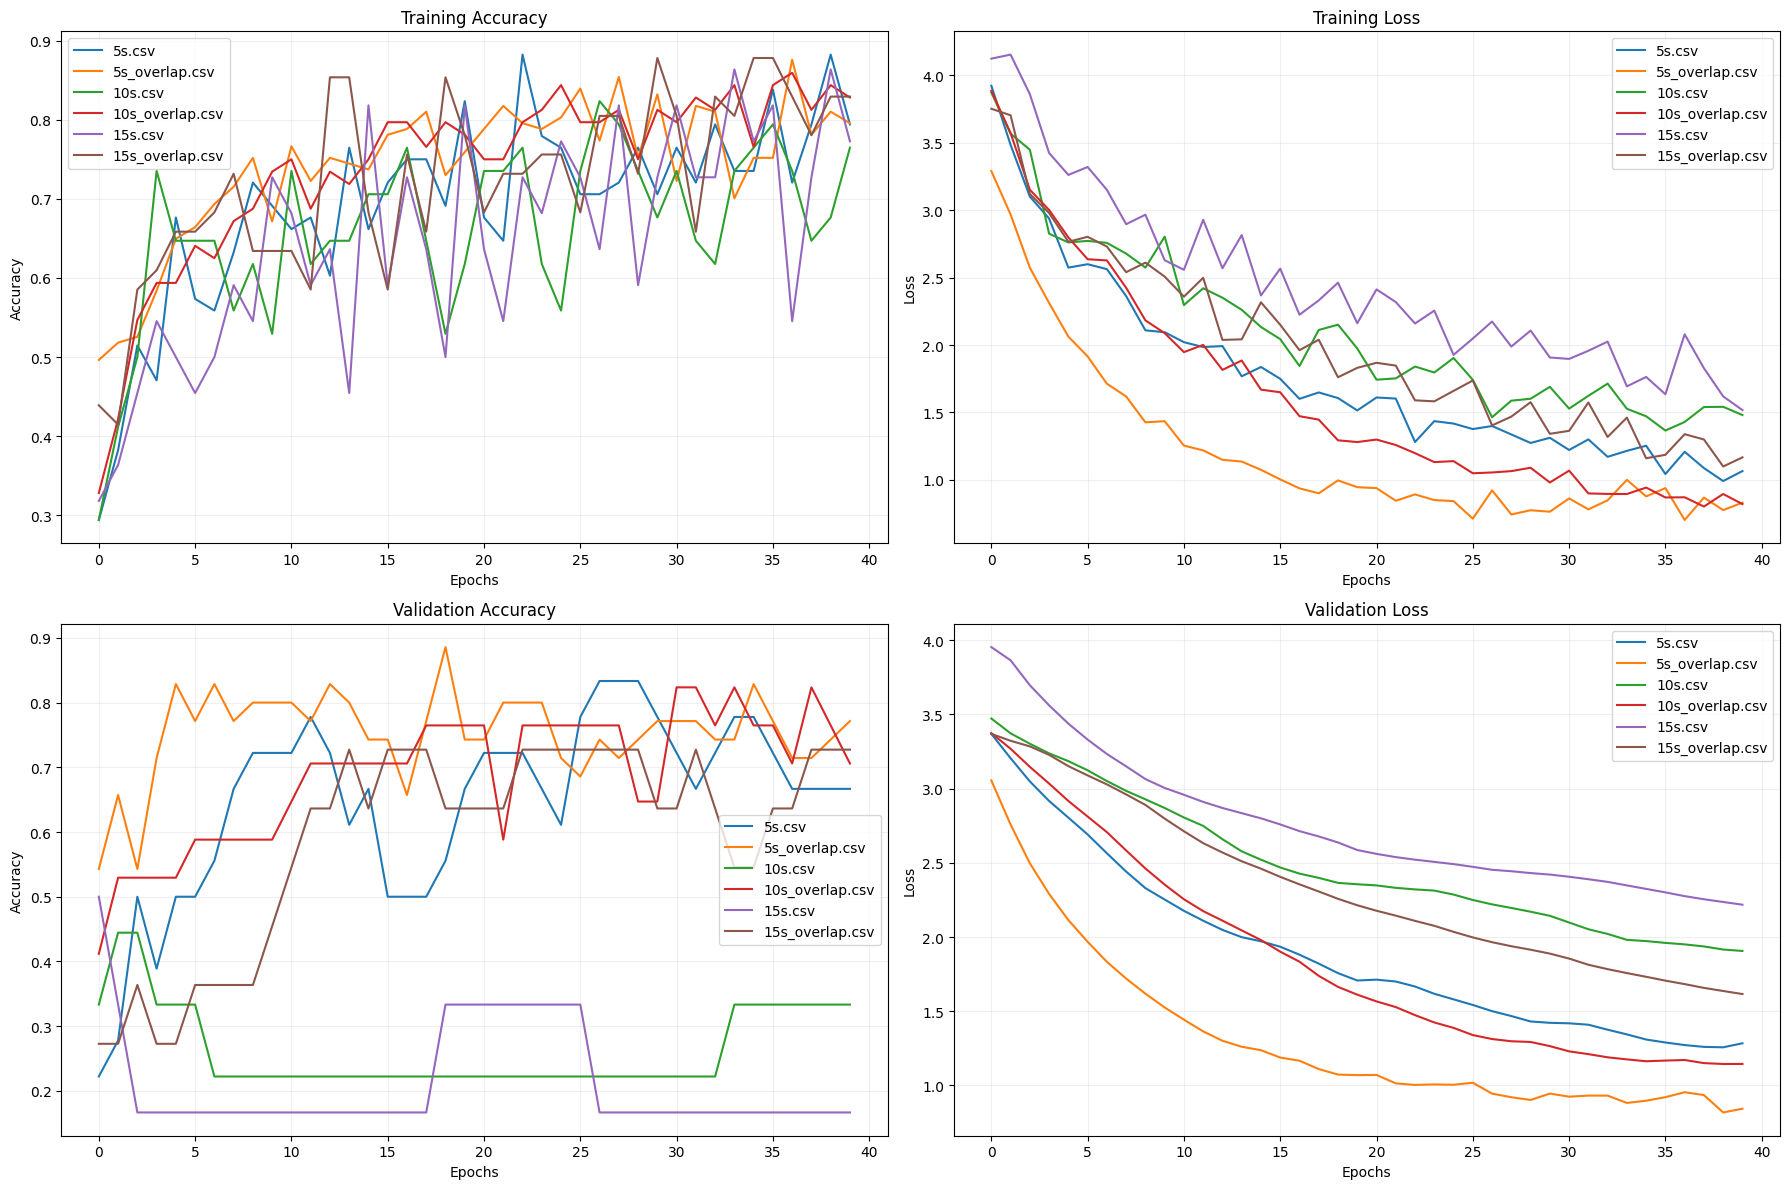

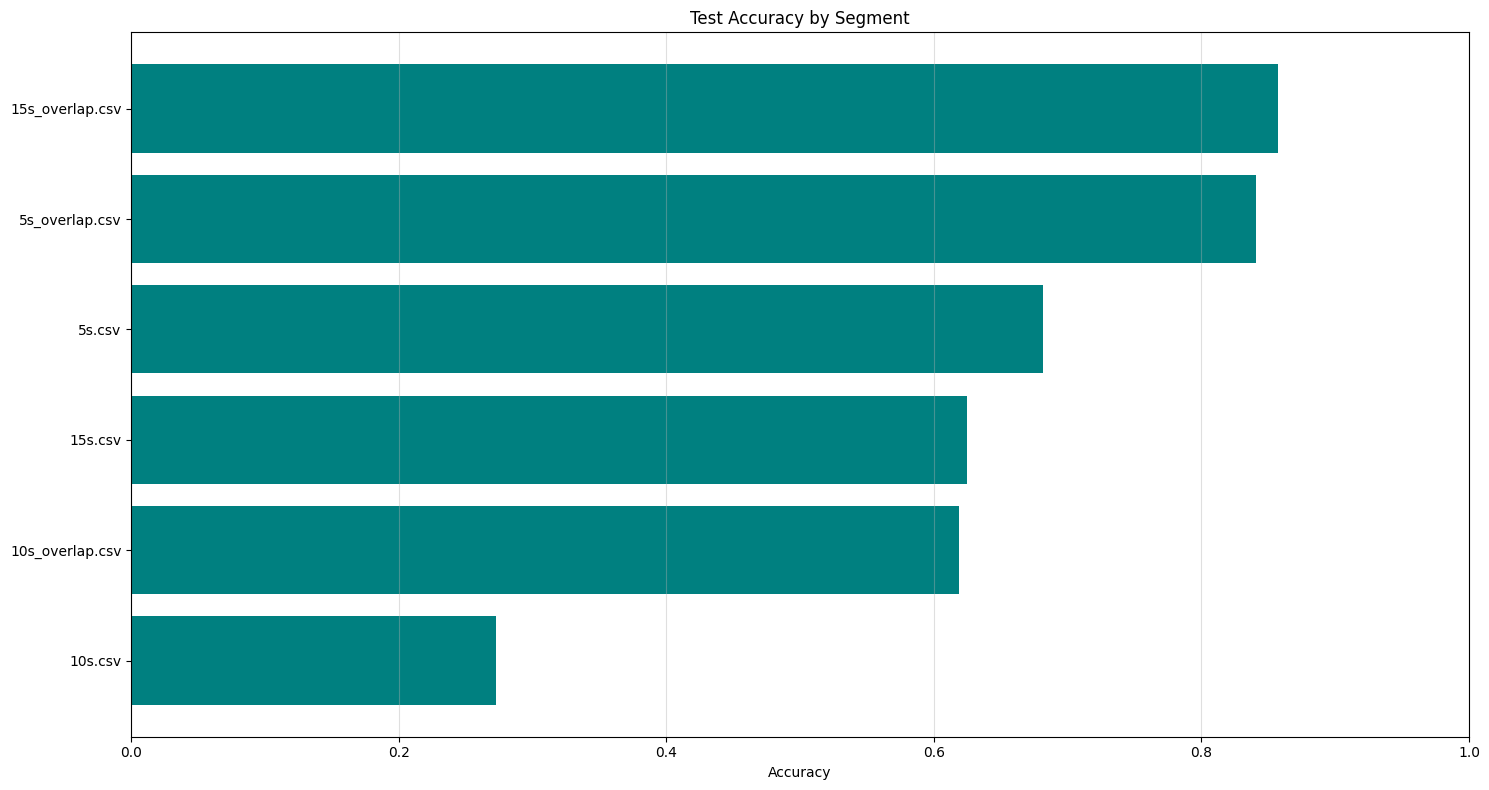

In [149]:
def main():
    segment_files = [
        'final_dataset_csv/5s.csv',
        'final_dataset_csv/5s_overlap.csv',
        'final_dataset_csv/10s.csv',
        'final_dataset_csv/10s_overlap.csv',
        'final_dataset_csv/15s.csv',
        'final_dataset_csv/15s_overlap.csv'
    ]
    run_pipeline(segment_files)

if __name__ == "__main__":
    main()


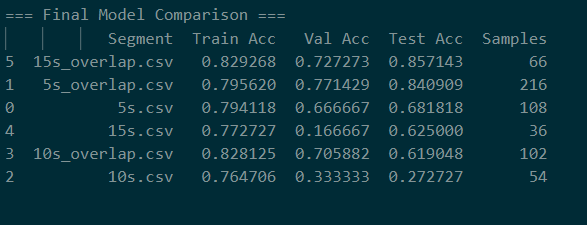